In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)


In [2]:
def zero_pad(x, pad):
    x_pad = np.pad(x, ((0,0),(pad,pad),(pad,pad),(0,0)), 'constant', constant_values = 0)
    return x_pad

x.shape =  (4, 3, 3, 2)
x_pad.shape =  (4, 7, 7, 2)
x[1,1] =  [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =  [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


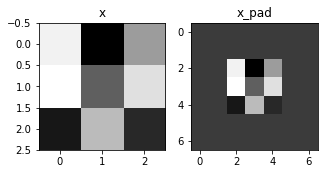

In [3]:
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_pad = zero_pad(x, 2)
print("x.shape = ", x.shape)
print("x_pad.shape = ", x_pad.shape)
print("x[1,1] = ", x[1,1])
print("x_pad[1,1] = ", x_pad[1,1])
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [4]:
def conv_single_step(a_slice_prev, w, b):
    s = np.multiply(a_slice_prev, w) + b
    z = np.sum(s)
    return z

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -23.16021220252078


In [6]:
def conv_forward(A_prev, W, b, hparameters):
    (m, n_h_prev, n_w_prev, n_c_prev) = A_prev.shape
    (f, f, n_c_prev, n_c) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    n_h = int((n_h_prev - f + (2 * pad)) / stride) + 1
    n_w = int((n_w_prev - f + (2 * pad)) / stride) + 1
    z = np.zeros((m, n_h, n_w, n_c))
    A_prev_pad = zero_pad(A_prev, pad)
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    z[i,h,w,c] = conv_single_step(a_slice_prev, W[...,c],b[...,c])
    assert(z.shape == (m,n_h, n_w,n_c))
    cache = (A_prev, W, b, hparameters)
    return z, cache
    

In [7]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [8]:
def pool_forward(A_prev, hparameters, mode="max"):
    (m, n_h_prev, n_w_prev, n_c_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]
    n_h = int(1 + (n_h_prev - f)/ stride)
    n_w = int(1 + (n_w_prev - f)/ stride)
    n_c = n_c_prev
    A = np.zeros((m,n_h,n_w,n_c))
    for i in range(m):
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end,c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    cache = (A_prev, hparameters)
    assert(A.shape == (m,n_h,n_w,n_c))
    return A, cache

In [9]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 1, "f": 4}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]

mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


In [10]:
def conv_backward(dz, cache):
    (A_prev, W, b, hparameters) = cache
    (m, n_h_prev, n_w_prev, n_c_prev) = A_prev.shape
    (f, f, n_c_prev, n_c) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    (m, n_h, n_w, n_c) = dz.shape
    dA_prev = np.zeros((m, n_h_prev, n_w_prev, n_c_prev))
    dW = np.zeros((f,f,n_c_prev,n_c))
    db = np.zeros((1, 1, 1, n_c))
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        for h in range(n_h):
            for w in range(n_w):
                for c in range(n_c):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dz[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dz[i, h, w, c]
                    db[:,:,:,c] += dz[i, h, w, c]
                    dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    assert(dA_prev.shape == (m, n_h_prev, n_h_prev, n_c_prev))
    return dA_prev, dW, db


In [11]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 9.608990675868995
dW_mean = 10.581741275547566
db_mean = 76.37106919563735


In [12]:
def create_mask_from_window(x):
    mask = x == np.max(x)
    return mask

In [13]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


In [14]:
def distribute_value(dz, shape):
    (n_h , n_w) = shape
    average = dz / (n_h * n_w)
    a = np.ones(shape) * average
    return a

In [15]:
a = distribute_value(2, (2,2))
print("Distributed value = ", a)

Distributed value =  [[0.5 0.5]
 [0.5 0.5]]


In [16]:
def pool_backward(dA, cache, mode = "max"):
    (A_prev, hparameters) = cache
    stride = hparameters["stride"]
    f = hparameters["f"]
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    dA_prev = np.zeros(A_prev.shape)
    for i in range(m):                       
        a_prev = A_prev[i]
        for h in range(n_H):                   
            for w in range(n_W):              
                for c in range(n_C):           
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
    assert(dA_prev.shape == A_prev.shape)
    return dA_prev

In [17]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
